# Inference Tasks on Stellar Spectra to Stellar Parameters

In [1]:
import h5py
import copy
import torch
import pylab as plt
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from astropy.stats import mad_std
from astroNN.gaia import fakemag_to_pc
from sklearn.preprocessing import StandardScaler
from astroNN.shared.matplotlib import pylab_style
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from stellarperceptron.model import StellarPerceptron

from utils.data_utils import shuffle_row
from utils.plotting_utils import plot_kiel_uncertainty, top_cbar

pylab_style(paper=True)

# ================== hardware-related settings ==================
device = "cuda:1"  #"cpu" for CPU or "cuda:x" for a NVIDIA GPU
mixed_precision = True
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
# ================== hardware-related settings ==================

nn_model = StellarPerceptron.load("./model_torch/", mixed_precision=mixed_precision, device=device)

xp_apogee_testing = h5py.File("./data_files/testing_set.h5", mode="r")
xp_apogee_training = h5py.File("./data_files/training_set.h5", mode="r")

# this notebook is about inference from XP spectra, so we at least need XP spectra and APOGEE labels
good_idx = (
    (np.sum(np.isnan(xp_apogee_testing["raw"]["xp_coeffs_gnorm"][()]), axis=1) == 0)
    & ~np.isnan(xp_apogee_testing["raw"]["teff"][()])
    & ~np.isnan(xp_apogee_testing["raw"]["logg"][()])
    & ~np.isnan(xp_apogee_testing["raw"]["m_h"][()])
)

val_labels = np.column_stack(
    [
        xp_apogee_testing["raw"]["xp_coeffs_gnorm"][()],
        xp_apogee_testing["raw"]["bprp"][()],
        xp_apogee_testing["raw"]["jh"][()],
        xp_apogee_testing["raw"]["jk"][()],
        xp_apogee_testing["raw"]["teff"][()],
        xp_apogee_testing["raw"]["logg"][()],
        xp_apogee_testing["raw"]["m_h"][()],
        xp_apogee_testing["raw"]["logc19"][()],
        xp_apogee_testing["raw"]["g_fakemag"][()],
    ]
)[good_idx]

obs_names = np.stack(
    [
        *[f"bp{i}" for i in range(55)],
        *[f"rp{i}" for i in range(55)],
        "bprp",
        "jh",
        "jk",
        "teff",
        "logg",
        "m_h",
        "logebv",
        "g_fakemag",
    ]
)

# create pandas DataFrame for validation set
val_labels_pd = pd.DataFrame(data=val_labels, columns=obs_names)
test_data_length = len(val_labels_pd)

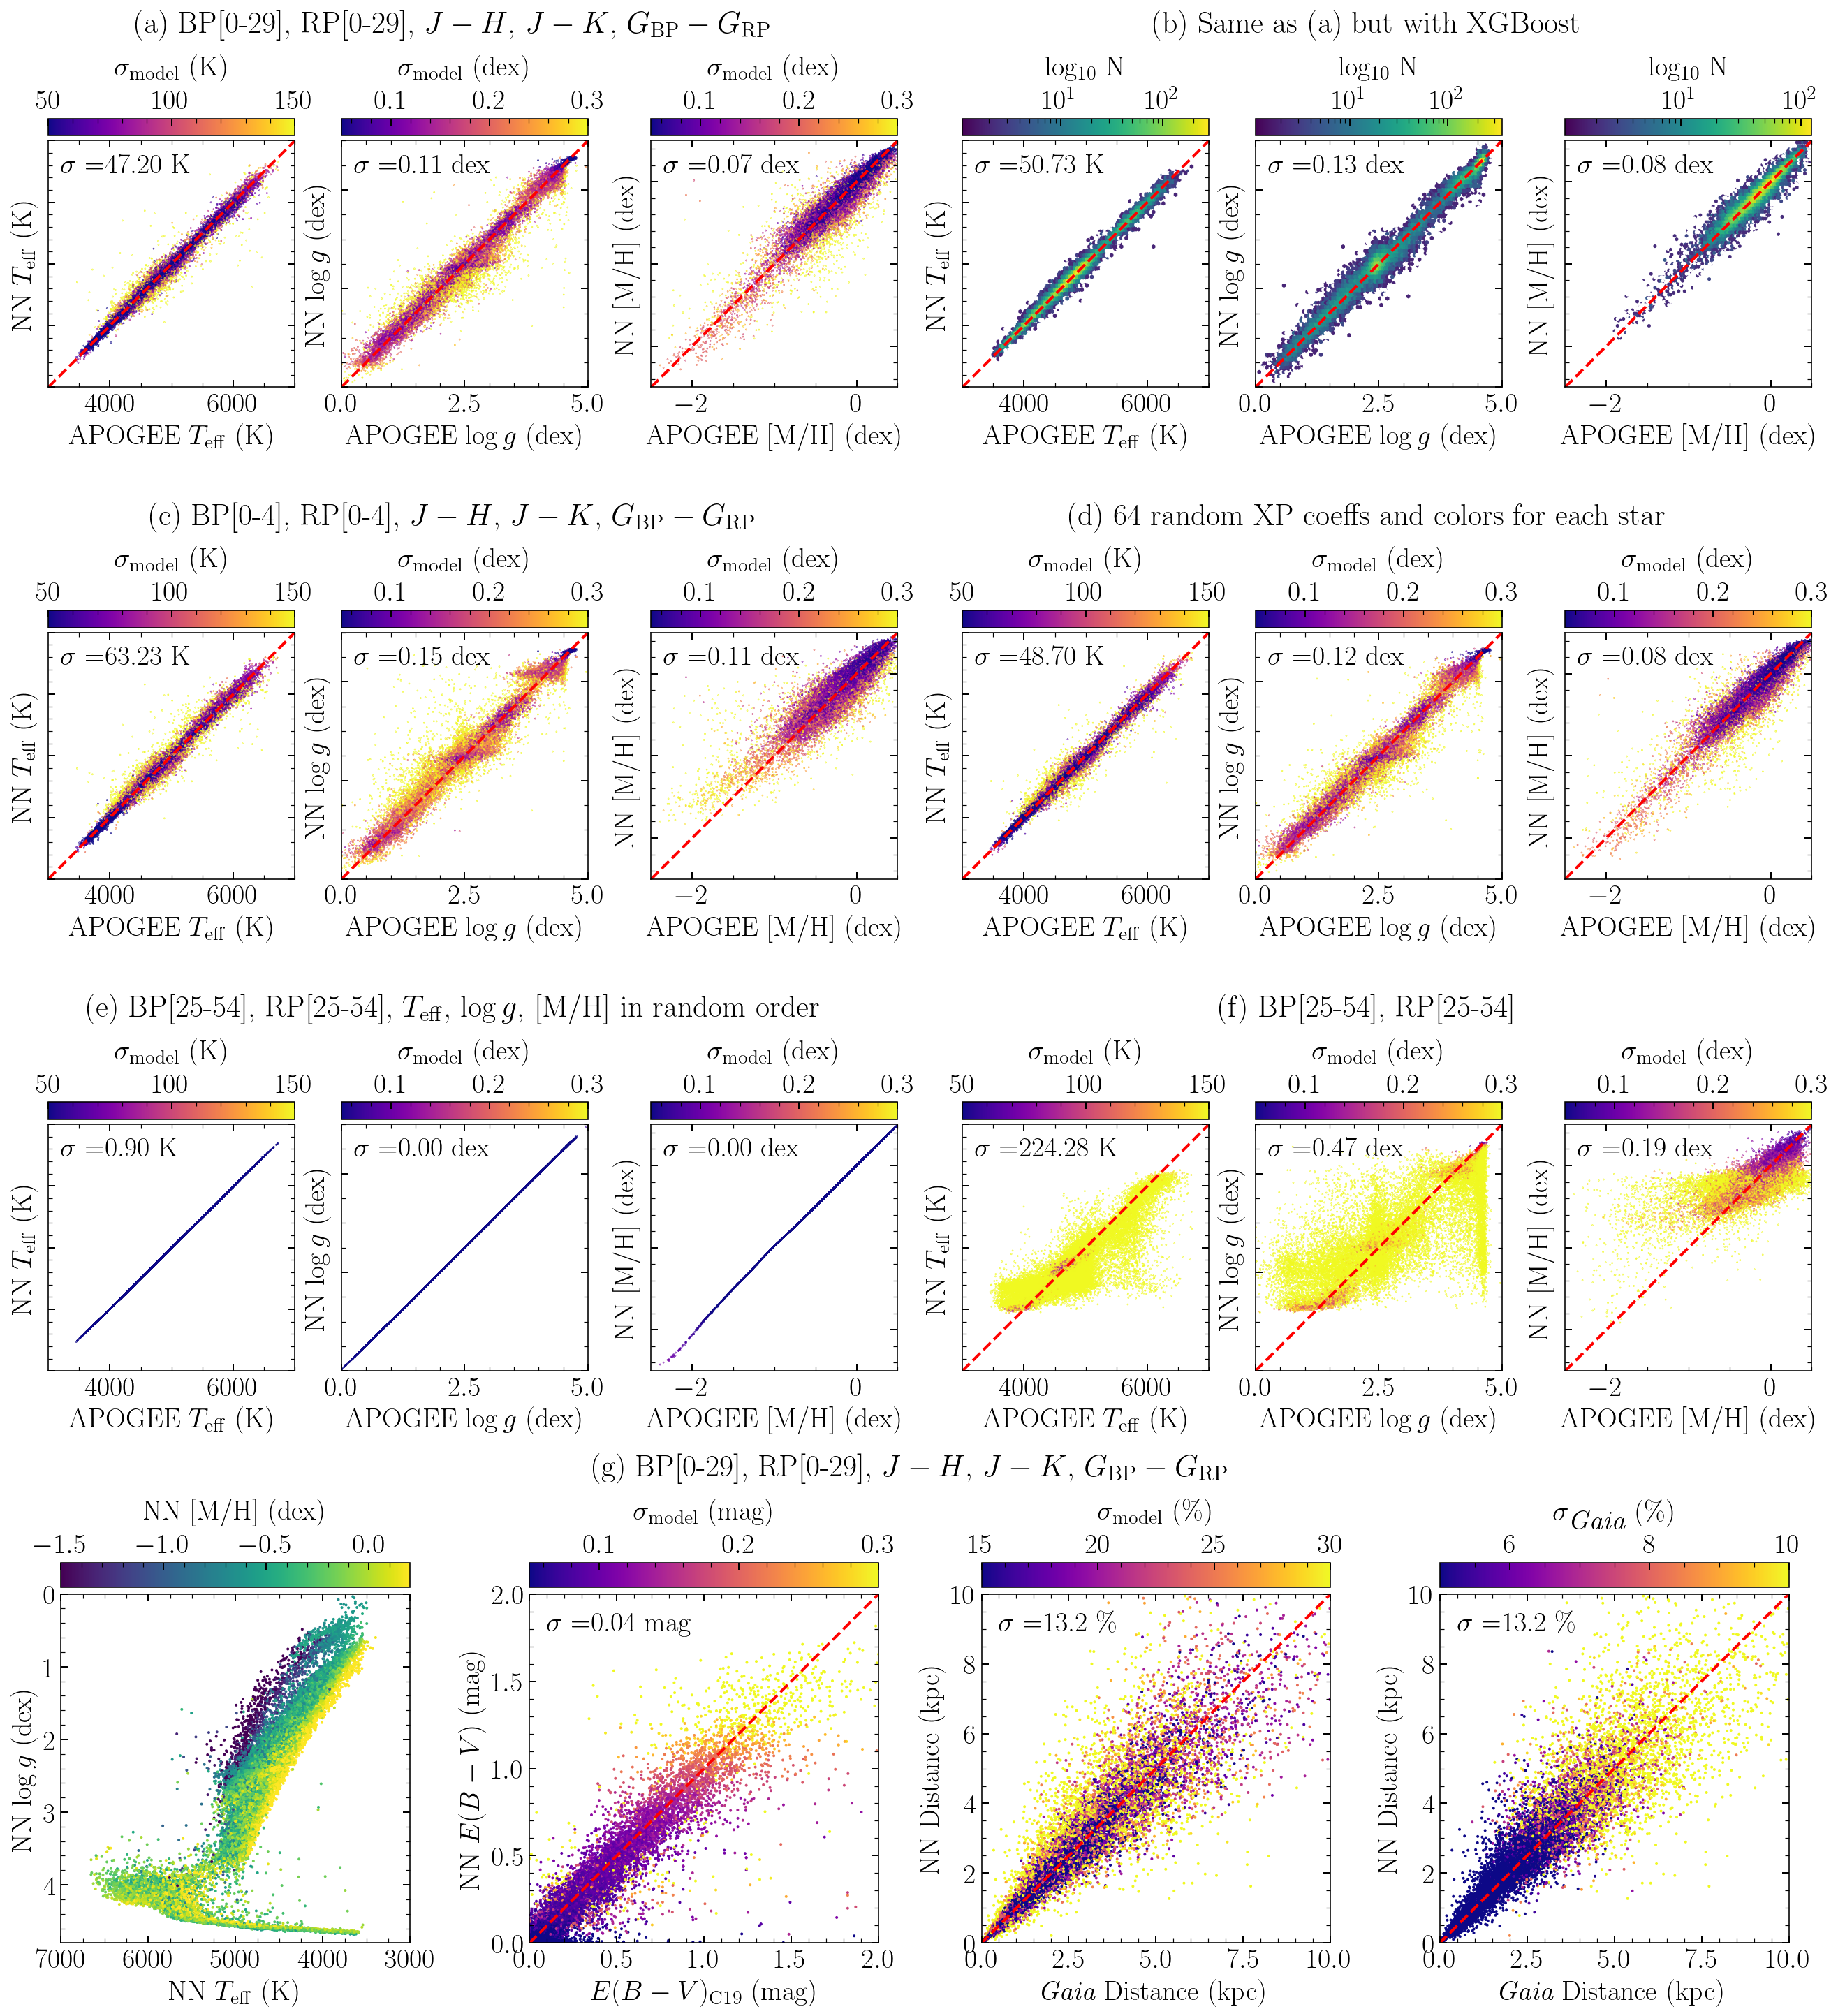

In [2]:
fig = plt.figure(constrained_layout=True, figsize=(18.0, 20.0))
bigsubfigs = fig.subfigures(
    4, 1, wspace=0.05, hspace=0.01, height_ratios=[1, 1, 1, 1.1]
)
subfigs_r0 = bigsubfigs[0].subfigures(1, 2)
subfigs_r1 = bigsubfigs[1].subfigures(1, 2)
subfigs_r2 = bigsubfigs[2].subfigures(1, 2)
subfigs_r3 = bigsubfigs[3].subplots(1, 4, gridspec_kw={"wspace": 0.05})

# ==============================================================================
col_names = [
    *[f"bp{i}" for i in range(30)],
    *[f"rp{i}" for i in range(30)],
    *["jh", "jk", "bprp"],
]

val_labels_shuffled = val_labels_pd[col_names]
val_labels_names = np.tile(col_names, (test_data_length, 1))
nn_model.perceive(
    val_labels_shuffled,
    val_labels_names,
)
pred_df = nn_model.request(["teff", "m_h", "logg"])
nn_model.clear_perception()
plot_kiel_uncertainty(
    val_labels_pd,
    pred_df=pred_df,
    suptitle="(a) BP[0-29], RP[0-29], $J-H$, $J-K$, $G_\mathrm{BP}-G_\mathrm{RP}$",
    fig=subfigs_r0[0],
)
# ==============================================================================

scaler_y = StandardScaler()
scaled_labels = scaler_y.fit_transform(
    np.column_stack(
        [
            xp_apogee_training["raw"]["teff"][()],
            xp_apogee_training["raw"]["logg"][()],
            xp_apogee_training["raw"]["m_h"][()],
        ]
    )
)

# training_labels = crop_xp(xp_apogee["normalized"]["bprp_coeffs"][()][good_idx], 80, mode="end")
scaler_x = StandardScaler()
scaled_inputs = scaler_x.fit_transform(
    np.column_stack(
        [
            xp_apogee_training["raw"]["xp_coeffs_gnorm"][:, :30],
            xp_apogee_training["raw"]["xp_coeffs_gnorm"][:, 55:85],
            xp_apogee_training["raw"]["jh"],
            xp_apogee_training["raw"]["jk"],
            xp_apogee_training["raw"]["bprp"],
        ]
    )
)

xgboost_reg = XGBRegressor(tree_method="gpu_hist", n_estimators=2000, gpu_id=1)
xg_good_idx = (~np.isnan(scaled_inputs)).all(axis=1) & (~np.isnan(scaled_labels)).all(
    axis=1
)
xgboost_reg.fit(scaled_inputs[xg_good_idx], scaled_labels[xg_good_idx])

xg_good_idx = (~np.isnan(val_labels_shuffled)).all(axis=1) & (
    ~np.isnan(val_labels_shuffled)
).all(axis=1)
ys_pred = scaler_y.inverse_transform(
    xgboost_reg.predict(scaler_x.transform(val_labels_shuffled.to_numpy()))
)
pred_df = {"teff": ys_pred[:, 0], "logg": ys_pred[:, 1], "m_h": ys_pred[:, 2]}

plot_kiel_uncertainty(
    val_labels_pd,
    pred_df=pred_df,
    suptitle="(b) Same as (a) but with XGBoost",
    fig=subfigs_r0[1],
    density=True,
)
# ==============================================================================
col_names = [
    *[f"bp{i}" for i in range(0, 5)],
    *[f"rp{i}" for i in range(0, 5)],
    *["jh", "jk", "bprp"],
]
val_labels_shuffled = val_labels_pd[col_names]
val_labels_names = np.tile(col_names, (test_data_length, 1))
nn_model.perceive(
    val_labels_shuffled,
    val_labels_names,
)
pred_df = nn_model.request(["teff", "m_h", "logg"])
nn_model.clear_perception()
plot_kiel_uncertainty(
    val_labels_pd,
    pred_df=pred_df,
    suptitle="(c) BP[0-4], RP[0-4], $J-H$, $J-K$, $G_\mathrm{BP}-G_\mathrm{RP}$",
    fig=subfigs_r1[0],
)
# ==============================================================================
col_names = [
    *[f"bp{i}" for i in range(55)],
    *[f"rp{i}" for i in range(55)],
    *["jh", "jk", "bprp"],
]

val_labels_names = np.tile(col_names, (test_data_length, 1))
val_labels_shuffled = val_labels_pd[col_names].to_numpy()
shuffle_row([val_labels_shuffled, val_labels_names])
nn_model.perceive(
    val_labels_shuffled[:, : nn_model.context_length],
    val_labels_names[:, : nn_model.context_length],
)
pred_df = nn_model.request(["teff", "m_h", "logg"])
nn_model.clear_perception()
plot_kiel_uncertainty(
    val_labels_pd,
    pred_df=pred_df,
    suptitle="(d) 64 random XP coeffs and colors for each star",
    fig=subfigs_r1[1],
)
# ==============================================================================
col_names = [
    *[f"bp{i}" for i in range(25, 55)],
    *["teff", "logg", "m_h"],
    *[f"rp{i}" for i in range(25, 55)],
]
val_labels_shuffled = val_labels_pd[col_names]
val_labels_names = np.tile(col_names, (test_data_length, 1))
val_labels_shuffled = val_labels_shuffled.to_numpy()
shuffle_row([val_labels_shuffled, val_labels_names])
nn_model.perceive(
    val_labels_shuffled,
    val_labels_names,
)
pred_df = nn_model.request(["teff", "m_h", "logg"])
nn_model.clear_perception()
plot_kiel_uncertainty(
    val_labels_pd,
    pred_df=pred_df,
    suptitle="(e) BP[25-54], RP[25-54], $T_\mathrm{eff}$, $\log{g}$, [M/H] in random order",
    plot_one_to_one=False,
    fig=subfigs_r2[0],
)
# ==============================================================================
col_names = [*[f"bp{i}" for i in range(25, 55)], *[f"rp{i}" for i in range(25, 55)]]

val_labels_shuffled = val_labels_pd[col_names]
val_labels_names = np.tile(col_names, (test_data_length, 1))
nn_model.perceive(
    val_labels_shuffled,
    val_labels_names,
)
pred_df = nn_model.request(["teff", "m_h", "logg"])
nn_model.clear_perception()
plot_kiel_uncertainty(
    val_labels_pd,
    pred_df=pred_df,
    suptitle="(f) BP[25-54], RP[25-54]",
    fig=subfigs_r2[1],
)

# ==============================================================================

col_names = [
    *[f"bp{i}" for i in range(30)],
    *[f"rp{i}" for i in range(30)],
    *["jh", "jk", "bprp"],
]

val_labels_shuffled = val_labels_pd[col_names]
val_labels_names = np.tile(col_names, (test_data_length, 1))
nn_model.perceive(
    val_labels_shuffled,
    val_labels_names,
)
pred_df = nn_model.request(["teff", "m_h", "logg", "logebv", "g_fakemag"])
nn_model.clear_perception()

ax1, ax2, ax3, ax4 = subfigs_r3[0], subfigs_r3[1], subfigs_r3[2], subfigs_r3[3]
bigsubfigs[3].suptitle(
    "(g) BP[0-29], RP[0-29], $J-H$, $J-K$, $G_\mathrm{BP}-G_\mathrm{RP}$",
    fontsize=22,
    y=1.06,
)
# need to manually scale teff so matplotlib works properly...
f = lambda teff: 4.8 * (np.asfarray(teff) - 3000) / 4000
mappable = ax1.scatter(
    f(pred_df["teff"]),
    pred_df["logg"],
    c=pred_df["m_h"],
    s=1,
    vmin=-1.5,
    vmax=0.2,
    rasterized=True,
)
ax1.set_xlim(4.8, 0.0)
ax1.set_ylim(4.8, 0.0)
ax1.set_xticks(f([3000, 4000, 5000, 6000, 7000]))
# ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.set_xticklabels([3000, 4000, 5000, 6000, 7000])
ax1.set_xlabel("NN $T_\mathrm{eff}$ (K)")
ax1.set_ylabel("NN $\log{g}$ (dex)")
ax1.set_aspect("equal", "box")
top_cbar(ax1, mappable, "NN [M/H] (dex)", labelpad=10)

mappable = ax2.scatter(
    np.exp(val_labels_pd["logebv"]),
    np.exp(pred_df["logebv"]),
    c=np.exp(pred_df["logebv"]) * pred_df["logebv_error"],
    s=1,
    vmin=0.05,
    vmax=0.3,
    cmap="plasma",
    rasterized=True,
)
ax2.annotate(
    f"$\\sigma=${mad_std(np.exp(val_labels_pd['logebv']) - np.exp(pred_df['logebv']), ignore_nan=True):.2f} mag",
    xy=(0.05, 0.95),
    xycoords=ax2,
    fontsize=20,
    ha="left",
    va="top",
)
ax2.plot([-999.0, 999], [-999.0, 999], c="r", lw=2, ls="--")
ax2.set_xlim(0, 2)
ax2.set_ylim(0, 2)
ax2.set_xlabel("$E(B-V)_\mathrm{C19}$ (mag)")
ax2.set_ylabel("NN $E(B-V)$ (mag)")
ax2.set_aspect("equal", "box")
top_cbar(ax2, mappable, "$\sigma_\mathrm{model}$ (mag)", labelpad=10)

gaia_dist_err = (
    xp_apogee_testing["raw"]["g_fakemag_err"][()][good_idx]
    / xp_apogee_testing["raw"]["g_fakemag"][()][good_idx]
)
good_parallax_idx = (
    xp_apogee_testing["raw"]["parallax_err"][()][good_idx]
    / xp_apogee_testing["raw"]["parallax"][()][good_idx]
    < 0.2
)
gaia_dist, gaia_dist_error = fakemag_to_pc(
    xp_apogee_testing["raw"]["g_fakemag"][()][good_idx][good_parallax_idx],
    xp_apogee_testing["raw"]["phot_g_mean_mag"][()][good_idx][good_parallax_idx],
    xp_apogee_testing["raw"]["g_fakemag_err"][()][good_idx][good_parallax_idx],
)
gaia_dist = gaia_dist.value
gaia_dist_error = gaia_dist_error.value

nn_dist, nn_dist_error = fakemag_to_pc(
    pred_df["g_fakemag"][good_parallax_idx],
    xp_apogee_testing["raw"]["phot_g_mean_mag"][()][good_idx][good_parallax_idx],
    pred_df["g_fakemag_error"][good_parallax_idx],
)
nn_dist = nn_dist.value

mappable = ax3.scatter(
    gaia_dist / 1000,
    nn_dist / 1000,
    c=100 * nn_dist_error / nn_dist,
    s=1,
    vmin=15,
    vmax=30,
    cmap="plasma",
    rasterized=True,
)
ax3.annotate(
    f"$\\sigma=${mad_std(100 * (gaia_dist - nn_dist) / gaia_dist, ignore_nan=True):.1f} \%",
    xy=(0.05, 0.95),
    xycoords=ax3,
    fontsize=20,
    ha="left",
    va="top",
)
ax3.plot([-999.0, 999], [-999.0, 999], c="r", lw=2, ls="--")
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 10)
ax3.set_xlabel("$\\textit{Gaia}$ Distance (kpc)")
ax3.set_ylabel("NN Distance (kpc)")
ax3.set_aspect("equal", "box")
top_cbar(ax3, mappable, "$\sigma_\\mathrm{model}$ (\%)", labelpad=10)

mappable = ax4.scatter(
    gaia_dist / 1000,
    nn_dist / 1000,
    c=100 * gaia_dist_error / gaia_dist,
    s=1,
    vmin=5,
    vmax=10,
    cmap="plasma",
    rasterized=True,
)
ax4.annotate(
    f"$\\sigma=${mad_std(100 * (gaia_dist - nn_dist) / gaia_dist, ignore_nan=True):.1f} \%",
    xy=(0.05, 0.95),
    xycoords=ax4,
    fontsize=20,
    ha="left",
    va="top",
)
ax4.plot([-999.0, 999], [-999.0, 999], c="r", lw=2, ls="--")
ax4.set_xlim(0, 10)
ax4.set_ylim(0, 10)
ax4.set_xlabel("$\\textit{Gaia}$ Distance (kpc)")
ax4.set_ylabel("NN Distance (kpc)")
ax4.set_aspect("equal", "box")
top_cbar(ax4, mappable, "$\sigma_\\textit{Gaia}$ (\%)", labelpad=10)


fig.savefig("./figs/teff_logg_mh.pdf", bbox_inches="tight", dpi=100)


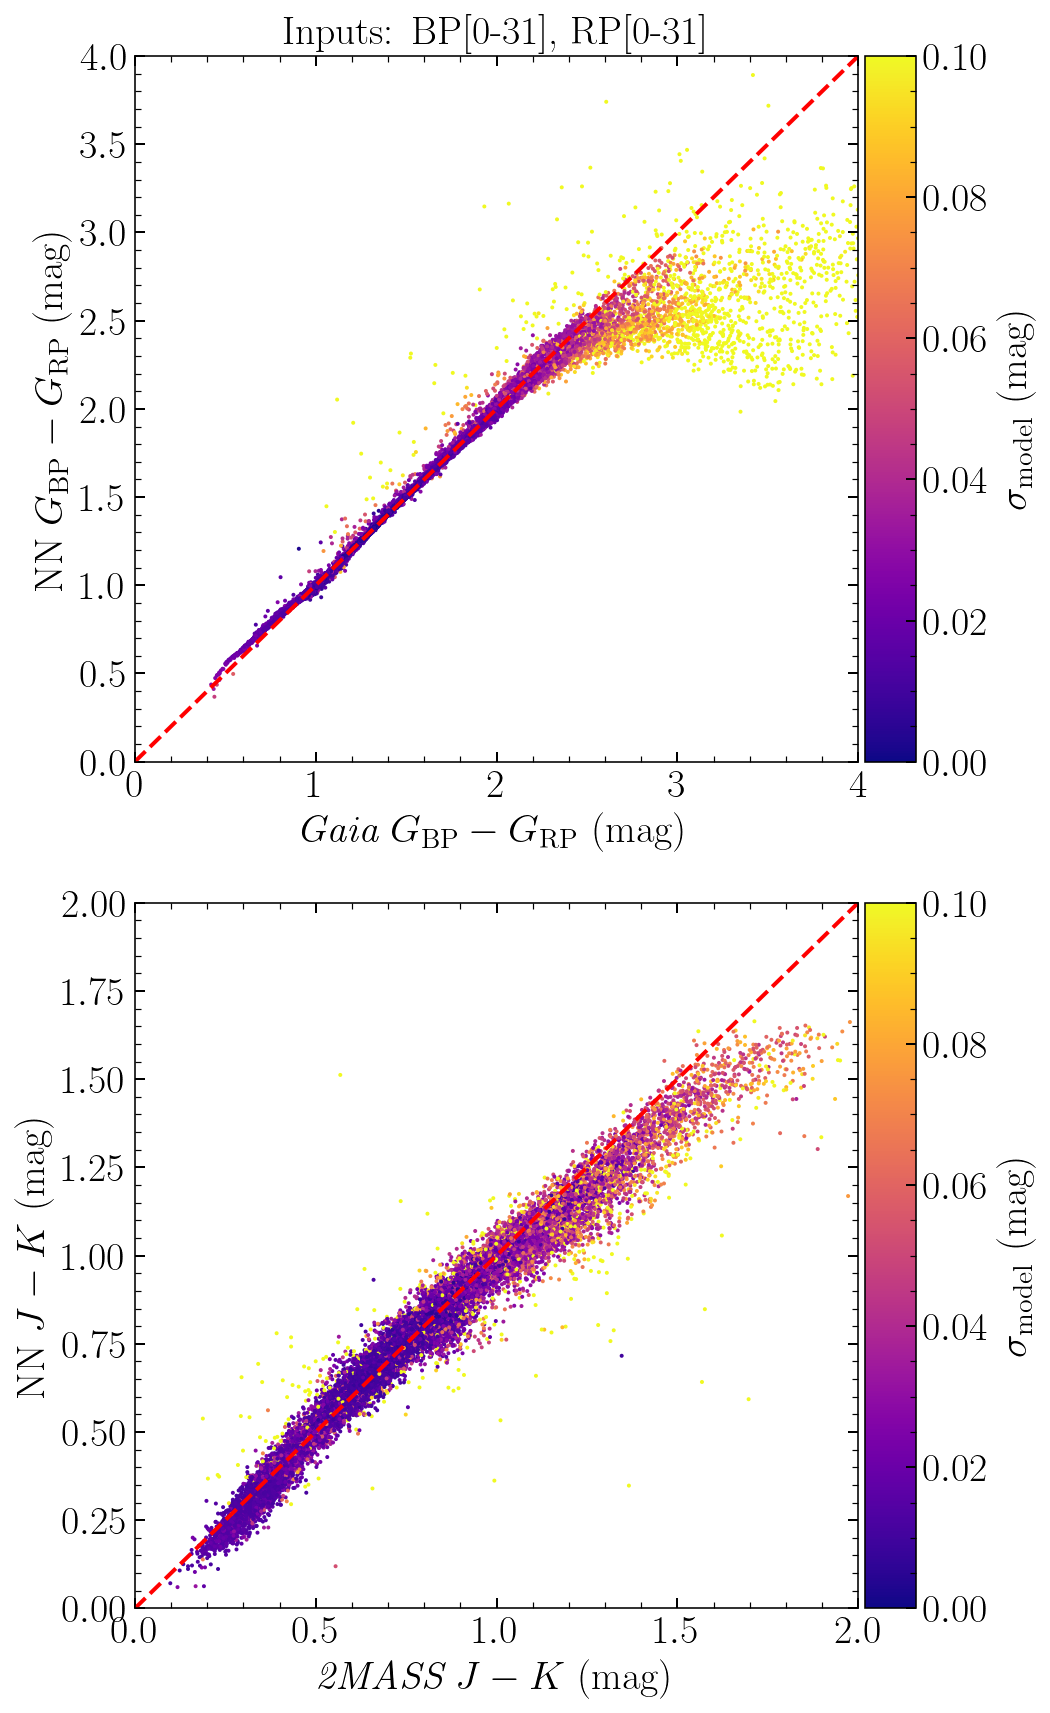

In [6]:
col_names = [*[f"bp{i}" for i in range(32)],*[f"rp{i}" for i in range(32)]]

val_labels_shuffled = val_labels_pd[col_names]
val_labels_names = np.tile(col_names, (test_data_length, 1))
nn_model.perceive(
    val_labels_shuffled,
    val_labels_names,
)
pred_df = nn_model.request(["bprp", "jk"])
nn_model.clear_perception()

fig = plt.figure(figsize=(7, 14))
subfigs = fig.subfigures(1, 1)
# ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8))
ax1, ax2 = subfigs.subplots(2, 1, gridspec_kw={"wspace": 0.2})

mappable = ax1.scatter(val_labels_pd["bprp"], pred_df["bprp"], c=pred_df["bprp_error"], s=1, cmap="plasma", vmin=0, vmax=0.1, rasterized=True)
ax1.plot([0., 4.], [0., 4.], color="r", ls="--", lw=2.)
ax1.set_xlabel("$\\textit{Gaia}$ $G_\mathrm{BP}-G_\mathrm{RP}$ (mag)")
ax1.set_ylabel("NN $G_\mathrm{BP}-G_\mathrm{RP}$ (mag)")
ax1.set_xlim(0., 4.0)
ax1.set_ylim(0., 4.0)
ax1.set_title("Inputs: BP[0-31], RP[0-31]")
ax_divider = make_axes_locatable(ax1)
cax = ax_divider.append_axes("right", size="7%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label("$\sigma_\mathrm{model}$ (mag)")

mappable = ax2.scatter(val_labels_pd["jk"], pred_df["jk"], c=pred_df["jk_error"], s=1, cmap="plasma", vmin=0, vmax=0.1, rasterized=True)
ax2.plot([0., 4.], [0., 4.], color="r", ls="--", lw=2.)
ax2.set_xlabel("$\\textit{2MASS}$ $J-K$ (mag)")
ax2.set_ylabel("NN $J-K$ (mag)")
ax2.set_xlim(0., 2.0)
ax2.set_ylim(0., 2.0)
ax_divider = make_axes_locatable(ax2)
cax = ax_divider.append_axes("right", size="7%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label("$\sigma_\mathrm{model}$ (mag)")
fig.savefig("./figs/new_requests.pdf", bbox_inches="tight", dpi=100)